# Traduction en français du notebook *12* du cours ***Deep Learning*** d'Alfredo Canziani, professeur assistant à la *New York University* :
https://github.com/Atcold/pytorch-Deep-Learning/blob/master/12-regularization.ipynb

## La régularisation dans les réseaux de neurones

Avant de commencer, il est important de comprendre le processus intuitif que nous essayons de faire en NLP lorsque nous traitons nos données du jeu de données IMDB :

1. Tokenisation : décomposer une phrase en mots individuels
    - Avant : `PyTorch semble vraiment facile à utiliser"`
    - Après : `["PyTorch", "semble", "vraiment", "facile", "à", "utiliser", " !"]`
2. Construire le vocabulaire : construire un index de mots associés à des nombres uniques
    - Avant : `["PyTorch", "semble", "vraiment", "facile", "à", "utiliser", " !"]`
    - Après : `{"Pytorch: 0, "semble": 1, "vraiment": 2, ...}`
3. Conversion en chiffres : les mots deviennent des nombres uniques (indices)
    - Avant : `{"Pytorch: 0, "semble": 1, "vraiment": 2, ...}`
    - Après : `[0, 1, 2, ...]`
4. Enchâssement : mise en correspondance des phrases (indices maintenant) avec des matrices fixes
    - ```[[0.1, 0.4, 0.3],
       [0.8, 0.1, 0.5],
       ...]```

In [1]:
# Importation des librairies :

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch 
from torchtext import data, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F

# Vérification de l'existence d'objets itératifs
import collections
import random

In [2]:
# Paramétrage de la graîne
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)

In [3]:
# Paramétrage des graphiques
plt.style.use(('dark_background', 'bmh'))
plt.rc('axes', facecolor='none')
plt.rc('figure', figsize=(16, 4))

In [4]:
# Créer des instances de champs
# Le champ important ici est fix_length : tous les exemples utilisant ce champ seront remplis, ou aucun pour les longueurs de séquence flexibles
# Nous réglons ce problème parce que nous utiliserons un FNN et non un LSTM/RNN/GRU où nous pouvons passer par des longueurs de séquence inégales

max_len = 80
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
label = data.LabelField(sequential=False, dtype=torch.float)

In [5]:
# Appel de la méthode splits() de datasets.IMDB pour renvoyer un objet torchtext.data.Dataset
datasets.IMDB.download('./')
ds_train, ds_test = datasets.IMDB.splits(text, label, path='./imdb/aclImdb/')

downloading aclImdb_v1.tar.gz


imdb\aclImdb_v1.tar.gz: 100%|█████████████████████████████████████████████████████| 84.1M/84.1M [00:36<00:00, 2.28MB/s]


In [6]:
# Entraînement et test de chaque série de 25k échantillons
# 2 champs en raison de la façon dont nous avons découpés les données

print('Entraînement : ', len(ds_train))
print('Test : ', len(ds_test))
print('Champs d entraînement :', ds_train.fields)

Entraînement :  25000
Test :  25000
Champs d entraînement : {'text': <torchtext.data.field.Field object at 0x000001F1BE590828>, 'label': <torchtext.data.field.LabelField object at 0x000001F1BE590898>}


In [7]:
# Avoir le jeu de validation
seed_num = 1337
ds_train, ds_valid = ds_train.split(random_state=random.seed(seed_num))

In [8]:
# Maintenant nous avons les jeux d'entraînement, de validation et de test
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('valid : ', len(ds_test))

train :  17500
valid :  7500
valid :  25000


In [9]:
# Création du vocabulaire
# num_words = 25000
num_words = 1000
text.build_vocab(ds_train, max_size=num_words)
label.build_vocab(ds_train)

In [10]:
# On affiche la tailel du vocabulaire
print('Taille du vocabulaire: {}'.format(len(text.vocab)))
print('Taille des labels: {}'.format(len(label.vocab)))

Taille du vocabulaire: 1002
Taille des labels: 2


In [11]:
# On affiche les textes qui reviennent le plus de fois dans le vocabulaire
most_common_samples = 10
print(text.vocab.freqs.most_common(most_common_samples))

[('the', 224168), ('a', 110990), ('and', 110299), ('of', 100428), ('to', 93062), ('is', 72441), ('in', 62906), ('i', 49714), ('this', 48864), ('that', 46090)]


In [12]:
# On affiche les labels qui reviennent le plus de fois
print(label.vocab.freqs.most_common())

[('neg', 8835), ('pos', 8665)]


In [13]:
# Label de l'échantillon 0
ds_train[0].label

'neg'

In [14]:
# Texte de l'échantillon 0: divisé en portions 
ds_train[0].text

['this',
 'movie',
 'is',
 'a',
 'lot',
 'like',
 'the',
 'movie',
 'hostel,',
 'except',
 'with',
 '*bad*',
 'acting',
 'and',
 'not',
 'much',
 'suspense.',
 'the',
 'gore',
 'elements',
 'are',
 'there,',
 'but',
 'you',
 "don't",
 'really',
 'feel',
 'anything',
 'for',
 'the',
 'characters,',
 'making',
 'the',
 'violence',
 'not',
 'very',
 'effective.',
 'some',
 'parts',
 'are',
 'just',
 'strange...',
 'like',
 'forcing',
 'a',
 'snake',
 'down',
 'someones',
 'throat.',
 "what's",
 'up',
 'with',
 'that?',
 'is',
 'that',
 'supposed',
 'to',
 'be',
 'scary',
 'or',
 'gory?',
 "it's",
 'just',
 'kind',
 'of',
 'stupid.',
 'as',
 'for',
 'torture,',
 'there',
 'really',
 "isn't",
 'any',
 '(except',
 'for',
 'the',
 'guy',
 'getting',
 'blow-torched',
 'in',
 'the',
 'beginning,',
 'which',
 'they',
 "don't",
 'show',
 'anyway).',
 'the',
 'main',
 'bad',
 'guy',
 'keeps',
 'saying',
 '"make',
 'them',
 'die',
 'slowly",',
 'yet',
 'the',
 'butcher',
 'kills',
 'them',
 'all',


In [15]:
# Texte de l'échantillon 0 : "lisible"
def show_text(sample):
    print(' '.join(word for word in sample))
    
show_text(ds_train[0].text)

this movie is a lot like the movie hostel, except with *bad* acting and not much suspense. the gore elements are there, but you don't really feel anything for the characters, making the violence not very effective. some parts are just strange... like forcing a snake down someones throat. what's up with that? is that supposed to be scary or gory? it's just kind of stupid. as for torture, there really isn't any (except for the guy getting blow-torched in the beginning, which they don't show anyway). the main bad guy keeps saying "make them die slowly", yet the butcher kills them all very fast. the deaths are all relatively quick. yes, i did watch the "unrated" version. so, overall, not the worst gore movie i've seen, but not at all good either. you won't miss anything if you skip this one.


In [16]:
# Créer un objet itératif pour nos ensembles d'entraînement, de validation et de test
# Regrouper des exemples de longueurs similaires afin de minimiser la quantité de rembourrage nécessaire
batch_size = 64  # Changez la taille du batch de 1 à un nombre plus important 
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False
)

In [17]:
# Vérifiez si l'itérateur ci-dessus est un itérable (devrait indiquer True)
isinstance(train_loader, collections.Iterable)

True

In [18]:
# Qu'y a-t-il à l'intérieur de cet objet itératif ?
# Notre texte et notre label,  bien que maintenant tout soit au format "machine" (pas de mots mais des chiffres) !
# Le texte que nous avons vu ci-dessus devient une matrice de taille 1 x 80 représentée par la longueur fixe que nous avons définie auparavant
list(train_loader)[0]


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.LongTensor of size 64x80]
	[.label]:[torch.FloatTensor of size 64]

In [19]:
# Une alternative qui est beaucoup plus rapide. Cependant le code ci-dessus est facile à comprendre et à mettre en œuvre
next(train_loader.__iter__())


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.LongTensor of size 64x80]
	[.label]:[torch.FloatTensor of size 64]

In [20]:
test_batch = next(train_loader.__iter__())

In [21]:
# A quelles méthodes peut-on faire appel via cet objet ? Texte et label
test_batch.fields

dict_keys(['text', 'label'])

In [22]:
# Décomposons cela pour vérifier ce qu'il y a dans un batch
test_batch.text

tensor([[ 12,  53,   0,  ..., 176,   6,  28],
        [  0, 189, 201,  ...,   0,   0,  56],
        [308, 945,   2,  ...,  83, 211,   0],
        ...,
        [  0,  29,   2,  ...,  76,   0,  25],
        [  0,   0,   0,  ...,  76,   7,   0],
        [ 32, 357, 631,  ...,   0,  27,   0]])

In [23]:
# 1 commentaire par batch, chaque commentaire est limité à une taille de 80 comme nous l'avons défini
test_batch.text.size()

torch.Size([64, 80])

In [24]:
test_batch.label

tensor([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 0., 1.])

In [25]:
# Problème extrêmement bizarre dans torchtext où BucketIterator renvoie un objet Batch par rapport à un simple tuple de tenseurs contenant notre index de texte et nos labels
# Alors réglons ça avec une nouvelle classe FixBatchGenerator

class FixBatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)
            
train_loader, valid_loader, test_loader = FixBatchGenerator(train_loader, 'text', 'label'), FixBatchGenerator(valid_loader, 'text', 'label'), FixBatchGenerator(test_loader, 'text', 'label')

In [26]:
# Texte index
print(next(train_loader.__iter__())[0])

# Texte label
print(next(train_loader.__iter__())[1])

tensor([[  0,   6,   2,  ...,  48, 155,   0],
        [404,  24,  11,  ...,   1,   1,   1],
        [ 10,   0,  14,  ...,  79,   2, 740],
        ...,
        [  0,  29,   3,  ...,   2, 231,  11],
        [  9,  98,   2,  ...,  17,  10, 714],
        [ 10,   7, 295,  ...,  16,   2,  82]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 0.])


In [27]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Couche d'enchâssement
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Fonction linéaire
        self.fc1 = nn.Linear(embedding_dim*embedding_dim, hidden_dim) 

        # Fonction linéaire (lecture)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Enchâssement
        embedded = self.embedding(x)
        embedded = embedded.view(-1, embedding_dim*embedding_dim)
        # Fonction linéaire
        out = self.fc1(embedded)

        # Fonction non linéaire
        out = torch.relu(out)
        
        # Dropout
        # out = torche.dropout(out, 0,8)

        # Fonction linéaire (lecture)
        # Prenez note ici d'utiliser une fonction finale sigmoïde afin que votre perte ne passe plus encore par la sigmoïde.
        # BCELoss est la bonne classe à utiliser car elle ne fait pas repasser votre sortie par une fonction sigmoïde.
        # Dans les problèmes multi-classes, vous êtes habitués à des softmax qui peuvent être simplifiés en une fonction
        # logistique lorsque vous avez un problème à deux classes.
        out = self.fc2(out)
        out = torch.sigmoid(out)
    
        return out

In [28]:
input_dim = num_words + 2
embedding_dim = max_len
hidden_dim = 32
output_dim = 1

# Instancier la classe modèle et l'attribuer à l'objet
model = FeedforwardNeuralNetModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Utilisation du GPU si disponile sinon CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Fonction de perte
criterion = nn.BCELoss()

# Optimiseur
# Possibilité d'ajouter une norme L2 (weight decay : décroissance du taux des poids)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
# Nombre de groupes de paramètres
print('Nombre de groupes de paramètres {}'.format(len(list(model.parameters()))))
print('-'*50)
# Afficher les paramètres
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
print('-'*50)

Nombre de groupes de paramètres 5
--------------------------------------------------
torch.Size([1002, 80])
torch.Size([32, 6400])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
--------------------------------------------------


In [30]:
iter = 0
num_epochs = 10
history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
best_accuracy = 0
for epoch in range(num_epochs):
#     print('-'*50)
    for i, (samples, labels) in enumerate(train_loader):
        # Mode entraînement
        model.train()
        
        # Charger les échantillons
        samples = samples.view(-1, max_len).to(device)
        labels = labels.view(-1, 1).to(device)

        # Supprimer les gradients w.r.t. 
        optimizer.zero_grad()

        # Passe avant pour obtenir les sorties/logits
        outputs = model(samples)

        # Calcule de la perte: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Norme L1, ajouter à la perte initiale
        # fc1_params = torch.cat([x.view(-1) for x in model.fc1.parameters()])
        # loss += 0.001 * torch.norm(fc1_params, 1)
    
        # Obtenir les gradients w.r.t. 
        loss.backward()

        # Mettre à jour les paramètres
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Obtenir les statistiques d'entraînement
            train_loss = loss.data.item()
            
            # Mode test
            model.eval()
            # Calcule de la précision         
            correct = 0
            total = 0
            # Iterer sur le jeu de données test
            for samples, labels in valid_loader:
                # Charger les échantillons
                samples = samples.view(-1, max_len).to(device)
                labels = labels.view(-1).to(device)

                # Passe avant pour obtenir les sorties/logits
                outputs = model(samples)
                
                # Perte de validation
                val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))
                
                # Nous utilisons un seuil. Cependant il y a une autre façon de le faire avec le label "one-hot".
                # N'hésitez pas à explorer et à comprendre les avantages et les inconvénients de chacun.
                # Cela ouvre tout un sujet sur les raisons pour lesquelles cela devient problématique lorsque nous passons de 2 à 10 classes.
                # Comme pourquoi ne pouvons-nous pas faire 0, 1, 2, 3, 4 etc. sans encodage en une seule fois ?
                predicted = outputs.ge(0.5).view(-1)

                # Nombre total de labels
                total += labels.size(0)

                # Total des predictions correctes
                correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()
                # correct = (predicted == labels.byte()).int().sum().item()
            
            accuracy = 100. * correct / total
        
            # Afficher la perte
            print('Iter: {} | Train Loss: {} | Val Loss: {} | Val Accuracy: {}'.format(iter, train_loss, val_loss.item(), round(accuracy, 2)))
            
            # Ajouter à l'historique
            history_val_loss.append(val_loss.data.item())
            history_val_acc.append(round(accuracy, 2))
            history_train_loss.append(train_loss)
            
            # Sauvegarde rle modèle quand la précision bat la meilleure précision
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                # Nous pouvons charger ce meilleur modèle sur le jeu de validation plus tard
                torch.save(model.state_dict(), 'best_model.pth')

Iter: 100 | Train Loss: 0.6755295991897583 | Val Loss: 0.7050830721855164 | Val Accuracy: 53.61
Iter: 200 | Train Loss: 0.6719903349876404 | Val Loss: 0.6675786972045898 | Val Accuracy: 54.23
Iter: 300 | Train Loss: 0.5782257318496704 | Val Loss: 0.8285977244377136 | Val Accuracy: 57.8
Iter: 400 | Train Loss: 0.4806445837020874 | Val Loss: 0.7255232930183411 | Val Accuracy: 59.05
Iter: 500 | Train Loss: 0.556922972202301 | Val Loss: 0.6713067889213562 | Val Accuracy: 60.84
Iter: 600 | Train Loss: 0.4356842041015625 | Val Loss: 0.7809162139892578 | Val Accuracy: 61.72
Iter: 700 | Train Loss: 0.41357526183128357 | Val Loss: 0.6379590630531311 | Val Accuracy: 63.08
Iter: 800 | Train Loss: 0.4290046691894531 | Val Loss: 0.6794511675834656 | Val Accuracy: 62.97
Iter: 900 | Train Loss: 0.32238900661468506 | Val Loss: 0.8009653687477112 | Val Accuracy: 64.11
Iter: 1000 | Train Loss: 0.23771999776363373 | Val Loss: 1.0143202543258667 | Val Accuracy: 63.91
Iter: 1100 | Train Loss: 0.10088983923

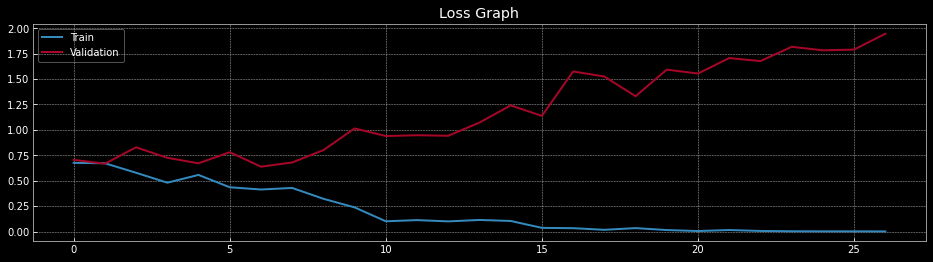

In [31]:
# Afficher le graphe de la perte
plt.plot(history_train_loss, label='Train')
plt.plot(history_val_loss, label='Validation')
plt.title('Loss Graph')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Validation Accuracy')

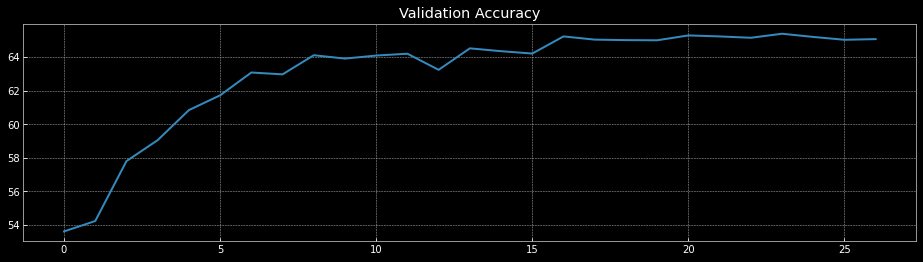

In [32]:
# Afficher le graphe de la précision sur l'échantillon de validation
plt.plot(history_val_acc)
plt.title('Validation Accuracy')

In [33]:
weights = torch.Tensor().to(device)
for param_group in list(model.parameters()):
    weights = torch.cat((param_group.view(-1), weights))
    print(param_group.size())
    
# 0: Pas de régularisation
weights_nothing = weights.cpu().detach().numpy()

# 1: Norme L1 sur FC1
weights_L1 = weights.detach().numpy()

# 2: Norme L2
weights_L2 = weights.detach().numpy()

# 3: dropout
# weights_dropout = weights.detach().numpy()

torch.Size([1002, 80])
torch.Size([32, 6400])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# plt.hist(weights_L1.reshape(-1), range=(-.5, .5), bins=20)

In [ ]:
# plt.hist(weights_nothing.reshape(-1), range=(-.5, .5), bins=20)

In [ ]:
# # Afficher la distribution des poids
# plt.hist((
#     weights_nothing.reshape(-1),
#     weights_L1.reshape(-1),
#     weights_L2.reshape(-1),
# ), 49, range=(-.5, .5), label=(
#     'No-reg',
#     'L1',
#     'L2',
# ))
# plt.legend();